## Import the TIF file as a numpy matrix

In [15]:
from PIL import Image
import numpy as np

tif_image = Image.open("map.tiff")
tif_matrix = np.array(tif_image)

tif_matrix = tif_matrix[0:40, 0:40]

print(tif_matrix)

[[  1.   1.   1. ...  10.  10.  10.]
 [  1.   1.   1. ...  10.  10.  10.]
 [ 10.  10.   1. ...  10.  10.  10.]
 ...
 [ 10.   1.   1. ...   1. 100. 100.]
 [ 10.   1.   1. ...   1. 100. 100.]
 [ 10.   1.   1. ...   1. 100.  10.]]


## Raster data

In [16]:
# return the type of a cell as a function of its value
def cell_type(v):
    v = int(v)
    if v == 1:
        return "habitat"
    if v == 10:
        return "field"
    if v == 100:
        return "road"    
    if 100 < v < 200:
        return "wildlife crossing"
    if 200 < v:
        return "land acquisition"
    raise ValueError(f"Unknown cell value '{v}'")
    
# return the option_id of a cell as a function of its value
def cell_option_id(v):
    v = int(v)   
    if 100 < v < 200:
        return str(v)
    if 200 < v:
        return str(v)
    return None
    
colors = {
    "habitat" : (64,  192, 64),
    "field" : (192, 255, 0),
    "road" : (255, 128, 0),
    "wildlife crossing" : (64,  128, 255),
    "land acquisition" : (192, 128, 192)
}
quality_map = {
    "habitat" : 1,
    "field" : 0,
    "road" : 0,
    "wildlife crossing" : 0,
    "land acquisition" : 0
}
probability_map = {
    "habitat" : 1,
    "field" : 0.98,
    "road" : 0.8,
    "wildlife crossing" : 0.8,
    "land acquisition" : 0.98
}
quality_gain_map = {
    "wildlife crossing" : 0,
    "land acquisition" : 1
}
improved_probability_map = {
    "wildlife crossing" : 0.95,
    "land acquisition" : 0.995
}
cell_cost = {
    "wildlife crossing" : 1,
    "land acquisition" : 0.2
}

instance_name = "instance_40x40"

## Visualize the TIF matrix

[]

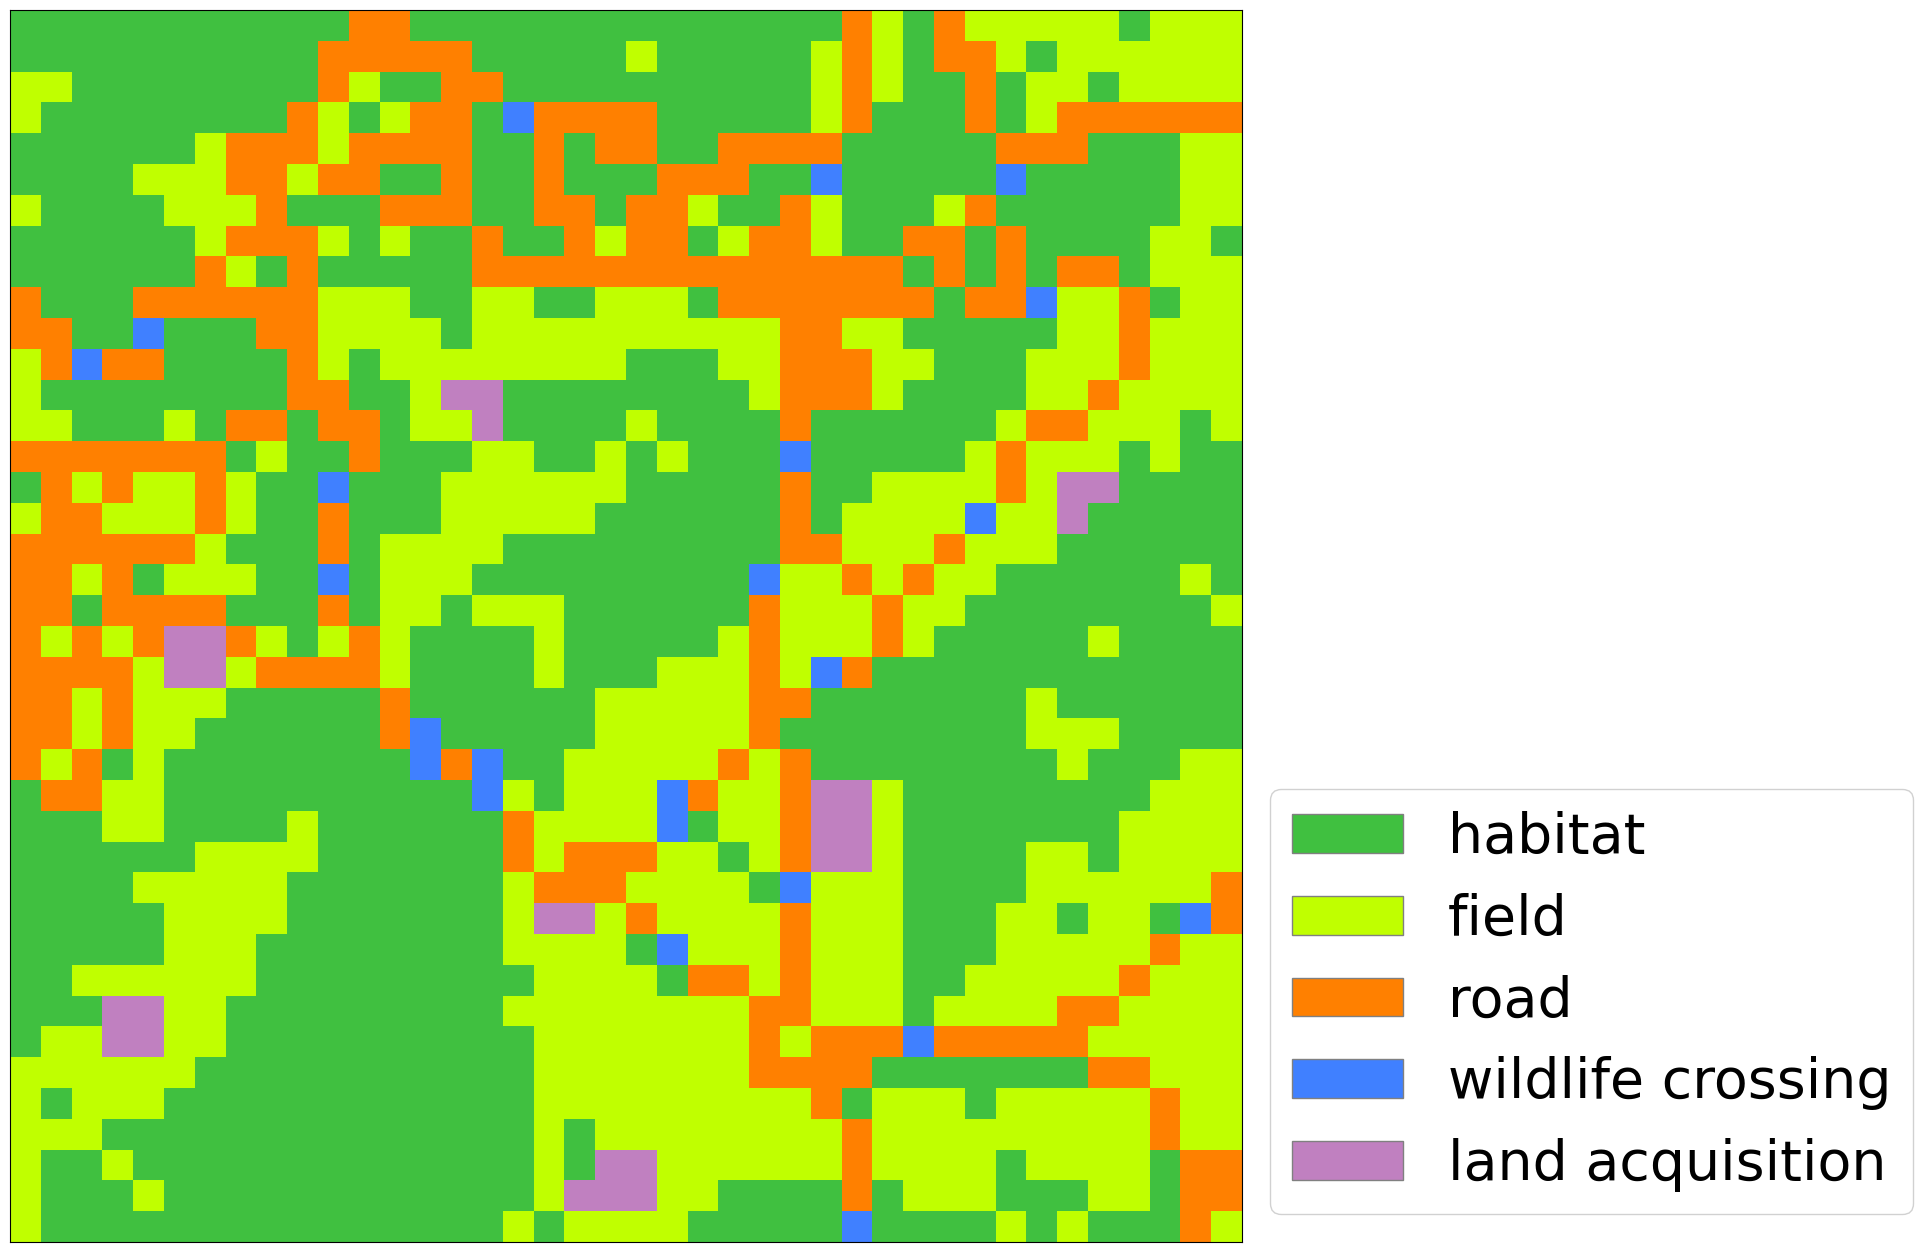

In [17]:
from PIL import Image


(width, height) = tif_matrix.shape
img = Image.new("RGB", (width, height))
pixels = img.load()
for idx, value in np.ndenumerate(tif_matrix):
    (y, x) = idx
    pixels[x, y] = colors[cell_type(value)]

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(img)

legend_patches = [mpatches.Patch(color=np.array(color)/255, label=color_id, ec=(0.5,0.5,0.5)) for color_id, color in colors.items()]
ax.legend(handles=legend_patches, fontsize=40, loc='lower left', framealpha=0.9, bbox_to_anchor=(1, 0))

ax.set_xticks([])
ax.set_yticks([])

## Create the csv files and declare utility functions

In [18]:
import os
import csv


def readCSVDict(file_name, id_column="id", delimiter=","):
    file = csv.DictReader(open(file_name), delimiter=delimiter)
    d = {}
    for row in file:
        d[row[id_column]] = row
    return d


def writeCSV(file_name, columns):
    file_path = file_name
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    file = open(file_path, "w")
    file.write(columns + "\n")
    return file

## Create vertices and arcs

In [19]:
import numpy as np
import itertools as it
import math

vertices_csv = writeCSV(f"{instance_name}/vertices.csv", "id,quality,x,y")
arcs_csv = writeCSV(f"{instance_name}/arcs.csv", "id,from,to,probability")


def add_vertex(id, quality, x, y):
    vertices_csv.write(f"{id},{quality},{x},{y}\n")


def add_arc(arc_id, source_id, target_id, probability):
    arcs_csv.write(f"{arc_id},{source_id},{target_id},{probability}\n")

offset_for_display = 0.33

(width, height) = tif_matrix.shape
for idx, value in np.ndenumerate(tif_matrix):
    (y, x) = idx
    id = f"{x}:{y}"
    quality = quality_map[cell_type(value)]
    probability = probability_map[cell_type(value)]
    
    

    add_vertex(id, quality, x, y)
    add_vertex(f"{id}_in", 0, x - offset_for_display, y - offset_for_display)
    add_vertex(f"{id}_out", 0, x + offset_for_display, y + offset_for_display)

    add_arc(f"{id}_in_arc", f"{id}_in", id, math.sqrt(probability))
    add_arc(f"{id}_out_arc", id, f"{id}_out", math.sqrt(probability))

    for to_x, to_y in [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]:
        if 0 <= to_x < width and 0 <= to_y < height:
            to_id = f"{to_x}:{to_y}"
            arc_id = f"{id}_to_{to_id}"
            add_arc(arc_id, f"{id}_out", f"{to_id}_in", 1)

vertices_csv.close()
arcs_csv.close()

## Create options

In [20]:
options_csv = writeCSV(f"{instance_name}/options.csv", "id,cost")
vertex_options_csv = writeCSV(
    f"{instance_name}/vertices_improvements.csv", "vertex_id,option_id,quality_gain"
)
arc_options_csv = writeCSV(f"{instance_name}/arcs_improvements.csv", "arc_id,option_id,improved_probability")


def add_option(option_id, cost):
    options_csv.write(f"{option_id},{cost}\n")

def add_vertex_option(vertex_id, option_id, quality_gain):
    vertex_options_csv.write(f"{vertex_id},{option_id},{quality_gain}\n")
    
def add_arc_option(arc_id, option_id, improved_prob):
    arc_options_csv.write(f"{arc_id},{option_id},{improved_prob}\n")

options = {}

for idx, value in np.ndenumerate(tif_matrix):
    (y, x) = idx
    id = f"{x}:{y}"
    value = int(value)
    cell_t = cell_type(value)
    cell_option = cell_option_id(value)
    if cell_option is None: continue
    
    if cell_option not in options: options[cell_option] = 0
    options[cell_option] += cell_cost[cell_t]

    quality_gain = quality_gain_map[cell_t]
    improved_prob = improved_probability_map[cell_t]
    
    if quality_gain > 0:
        add_vertex_option(id, value, quality_gain)        
        
    if improved_prob > probability_map[cell_t]:
        add_arc_option(f"{id}_in_arc", value, math.sqrt(improved_prob))
        add_arc_option(f"{id}_out_arc", value, math.sqrt(improved_prob))
        
for id, cost in options.items():
    add_option(id, cost)

options_csv.close()
vertex_options_csv.close()
arc_options_csv.close()

## Compute and display solution

Download and extract the genrated zip file, then run:
```
gecot_optimize prep_mip instance.json <budget> -p -v --output-json solution.json
```
and copy/paste the solution below.

[]

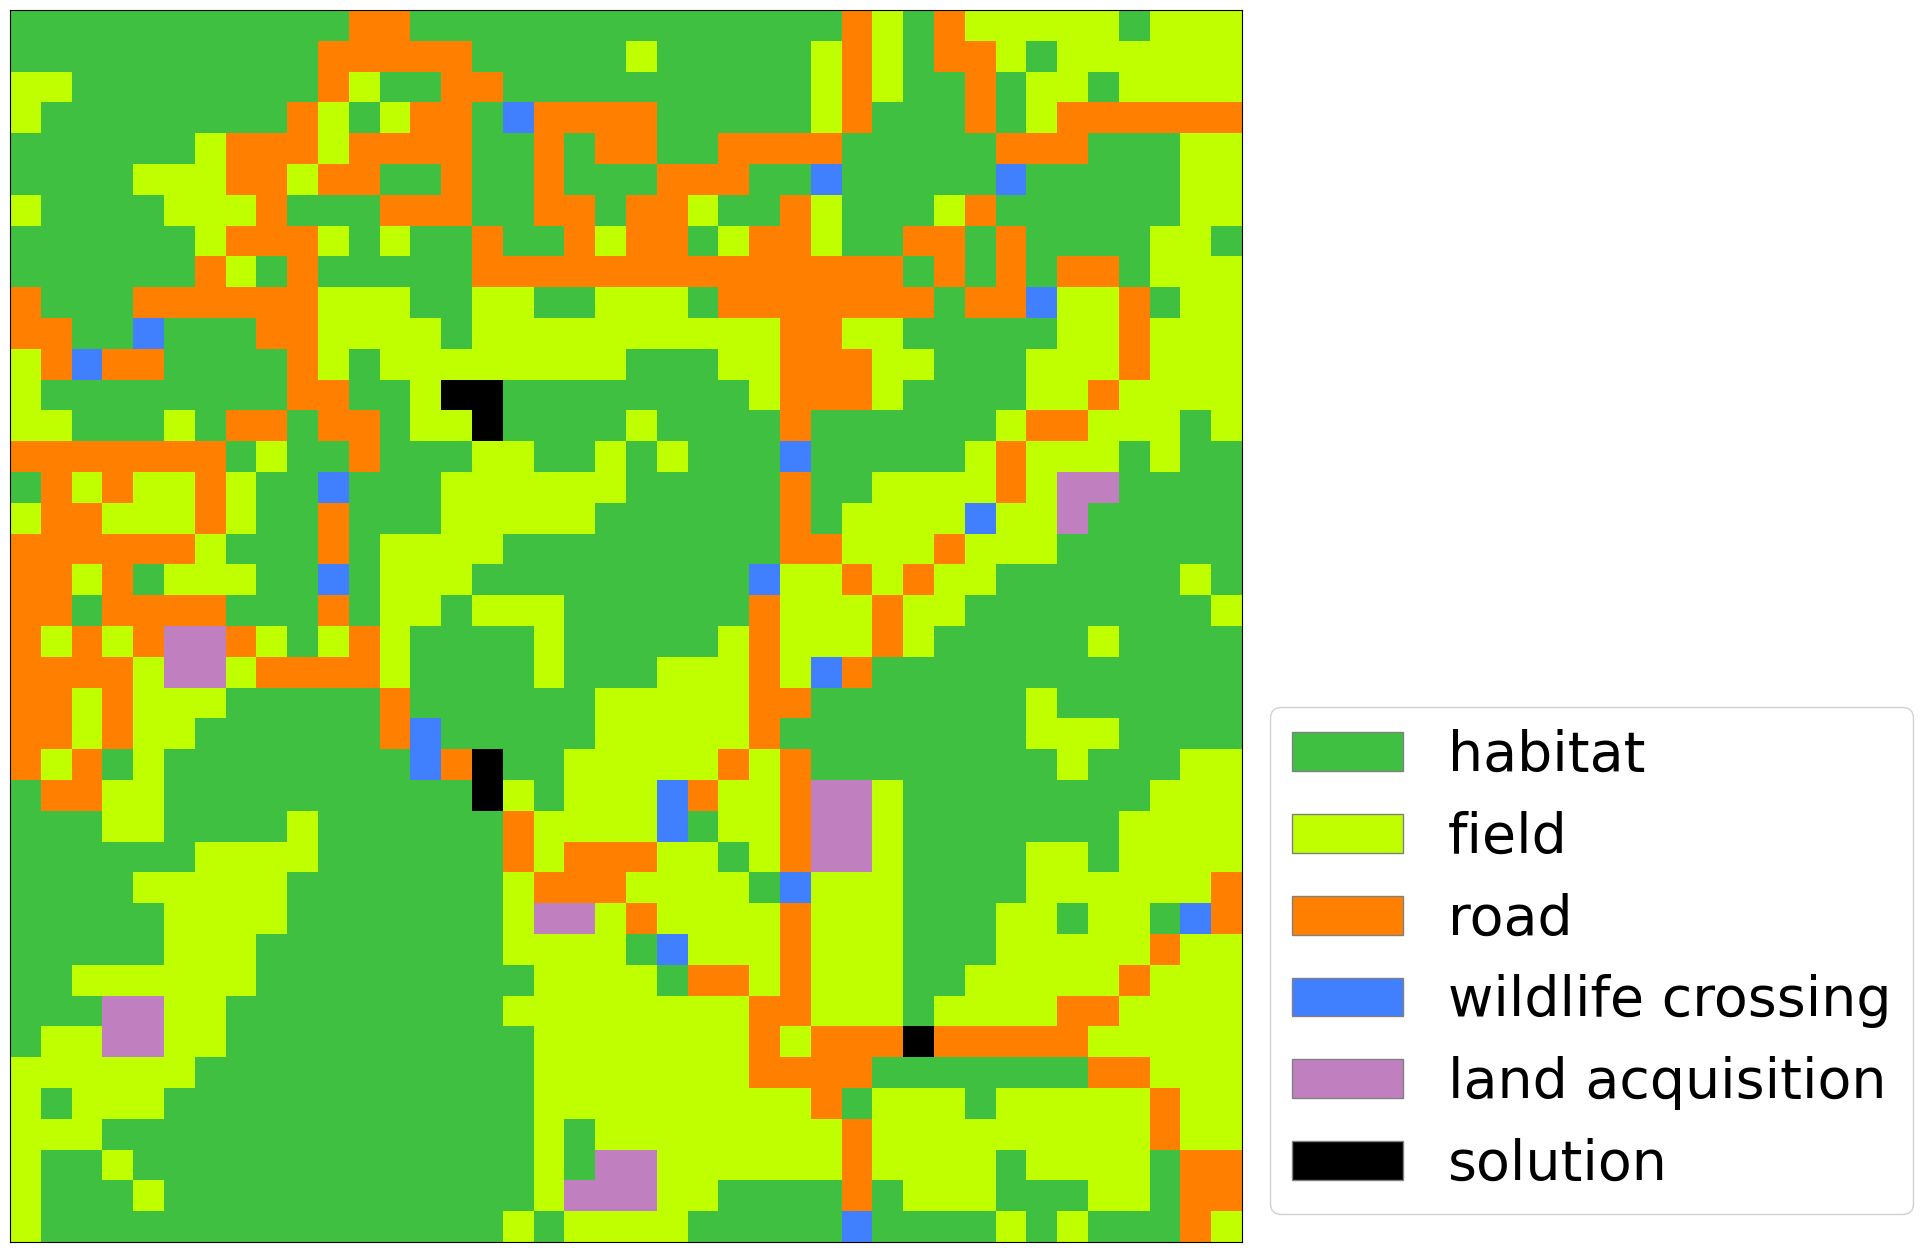

In [21]:
solution = {
        "218": 0,
        "125": 0,
        "145": 0,
        "109": 1,
        "126": 0,
        "124": 0,
        "108": 1,
        "138": 0,
        "117": 0,
        "116": 0,
        "202": 1,
        "204": 0,
        "139": 0,
        "207": 1,
        "102": 0,
        "107": 1,
        "115": 0,
        "216": 0,
        "137": 0,
        "106": 1,
        "118": 0,
        "121": 0,
        "210": 0,
        "212": 1,
        "206": 0,
        "120": 0,
        "101": 0,
        "114": 1,
        "211": 0,
        "110": 0,
        "128": 0,
        "201": 0,
        "111": 0,
        "119": 0,
        "214": 0,
        "132": 0,
        "127": 0,
        "213": 0,
        "122": 1,
        "131": 0,
        "134": 0,
        "209": 0,
        "133": 0,
        "208": 0,
        "113": 0,
        "129": 0,
        "217": 0,
        "112": 1,
        "130": 0,
        "105": 1,
        "141": 0,
        "140": 0,
        "205": 1,
        "215": 0,
        "219": 0,
        "144": 0,
        "104": 0,
        "203": 0,
        "123": 1,
        "143": 0,
        "220": 0,
        "103": 1,
        "135": 0,
        "142": 0,
        "136": 0
    }

solution_color = (0,0,0)

sol_img = Image.new("RGB", (width, height))
pixels = sol_img.load()
for idx, value in np.ndenumerate(tif_matrix):
    (y, x) = idx
    pixels[x, y] = colors[cell_type(value)]
    cell_option = cell_option_id(value)
    if cell_option is None: continue
    if solution[cell_option]:
        pixels[x, y] = solution_color
       
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(sol_img)

sol_legend_patches = legend_patches + [mpatches.Patch(color=np.array(solution_color)/255, label="solution", ec=(0.5,0.5,0.5))]
ax.legend(handles=sol_legend_patches, fontsize=40, loc='lower left', framealpha=0.9, bbox_to_anchor=(1, 0))

ax.set_xticks([])
ax.set_yticks([])